<a href="https://colab.research.google.com/github/lovezoyaxu/Q-learning-on-Cartpole/blob/main/Q_learning_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **env基本信息**

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
s = env.reset()
print('High: ', env.observation_space.high,
      '\nLow: ',env.observation_space.low)
"""
High:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
"""


High:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38] 
Low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


'\nHigh:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]\nLow:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]\n'

# **cartpole测试+无模型运动轨迹**

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

High:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38] 
Low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


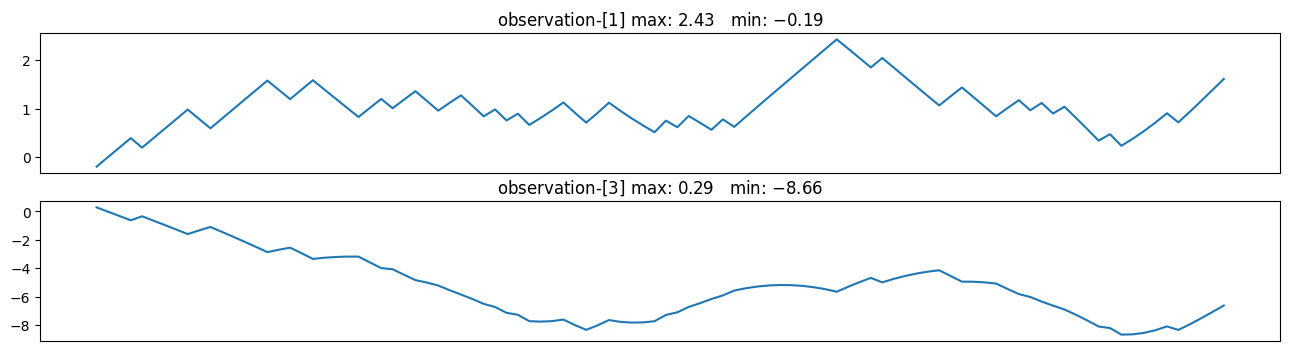

In [ ]:

env = gym.make('CartPole-v1')
s = env.reset()
print('High: ', env.observation_space.high,
      '\nLow: ',env.observation_space.low)
np.round(-4.1887903e-01, 1)

ob_list = []
for _ in range(100):
    env.render()
    a = env.action_space.sample()
    n_state, reward, done, info = env.step(a)
    ob_list.append(np.take(n_state, [1, 3]))

env.close()

ob_arr = np.stack(ob_list)
fig, axes = plt.subplots(2, 1, figsize=(16, 4))
for i in range(2):
    axes[i].plot(ob_arr[:, i])
    max_ = ob_arr[:, i].max()
    min_ = ob_arr[:, i].min()
    x = 1 if i == 0 else 3
    axes[i].set_title(f'observation-[{x}] max: ${max_:.2f}$   min: ${min_:.2f}$')
    axes[i].set_xticks([])

plt.show()



In [ ]:
#定义一个Agent类。
#如此定义的好处会在大工程中显现。
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
    def update_Q_function(self, observation, action, reward, observation_next):
        self.brain.update_Q_table(
            observation, action, reward, observation_next)
    def get_action(self, observation, step):
        action = self.brain.decide_action(observation, step)
        return action


# **Cart agent**

In [ ]:

class CartPoleActor:
    def __init__(self, env, epsilon=-1, round_num=2):
        self.epsilon = epsilon
        self.round_num = round_num
        self.actions = list(range(env.action_space.n))
        self.a_low, self.b_low = np.round(np.take(env.observation_space.low, [0, 2]), self.round_num)
        self.a_high, self.b_high = np.round(np.take(env.observation_space.high, [0, 2]), self.round_num)
        self.Q = self.__make_Q_table()

    def get_distrubution_arr(self, a_low, a_high, round_num):
        a_cnt = int((a_high - a_low) * (10 ** round_num) + 1)
        a = np.round(np.linspace(a_low, a_high, a_cnt), round_num)
        if not np.sum(0 == a):
            a = np.concatenate([a, np.array([-0., 0.])])
        else:
            a = np.concatenate([a, np.array([-0.])])
        return a

    def __make_Q_table(self):
        a = self.get_distrubution_arr(self.a_low, self.a_high, self.round_num)
        b = self.get_distrubution_arr(-3., 3., self.round_num)
        c = self.get_distrubution_arr(self.b_low, self.b_high, self.round_num)
        d = self.get_distrubution_arr(-3., 3., self.round_num)
        Q_dict = dict()
        for s1 in a:
            for s2 in b:
                for s3 in c:
                    for s4 in d:
                        Q_dict[str(np.round(np.array([s1, s2, s3, s4]), self.round_num))
                            ] = np.random.uniform(0, 1, len(self.actions))
        print('len(Q_dict) = ', len(Q_dict))
        return Q_dict

    @staticmethod
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def policy(self, s):

        return np.random.choice(self.actions, size=1,
                                p=self.softmax(self.Q[s]))[0]


# **正式训练**

len(Q_dict) =  3767120
Epoch [0]: balance last 18.00 (+/- 0.000) times - rewards 1.000
Epoch [50]: balance last 27.22 (+/- 14.661) times - rewards 1.000
Epoch [100]: balance last 26.04 (+/- 14.675) times - rewards 1.000
Epoch [150]: balance last 33.86 (+/- 22.435) times - rewards 1.000
Epoch [200]: balance last 39.76 (+/- 21.007) times - rewards 1.000
Epoch [250]: balance last 37.98 (+/- 20.692) times - rewards 1.000
Epoch [300]: balance last 33.88 (+/- 15.431) times - rewards 1.000
Epoch [350]: balance last 37.38 (+/- 22.903) times - rewards 1.000
Epoch [400]: balance last 41.90 (+/- 23.718) times - rewards 1.000
Epoch [450]: balance last 39.62 (+/- 24.372) times - rewards 1.000
Epoch [500]: balance last 35.44 (+/- 19.023) times - rewards 1.000
Epoch [550]: balance last 45.24 (+/- 22.476) times - rewards 1.000
Epoch [600]: balance last 45.74 (+/- 25.744) times - rewards 1.000
Epoch [650]: balance last 40.08 (+/- 22.629) times - rewards 1.000
Epoch [700]: balance last 42.02 (+/- 24.561

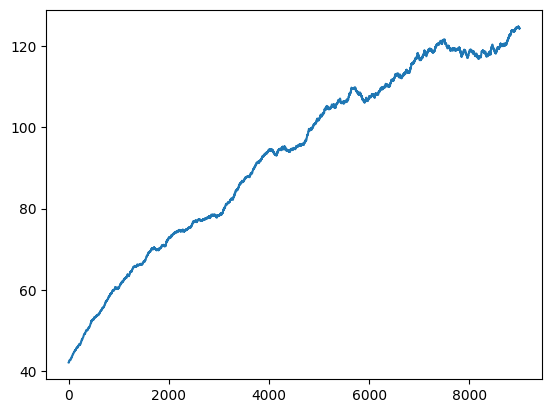

In [ ]:
class CartPoleMontoCarlo:
    def __init__(self, actor_cls, round_num):
        self.actor_cls = actor_cls
        self.round_num = round_num

    def take_state(self, state):
        if type(state) == str:
            return state
        s1, s2, s3, s4 = np.round(state, self.round_num)
        s1 = np.clip(s1, -4.8, 4.8)
        s2 = np.clip(s3, -3., 3.)
        s3 = np.clip(s2, -0.4, 0.4)
        s4 = np.clip(s4, -3., 3.)
        return str(np.round(np.array([s1, s2, s3, s4]), self.round_num))

    def train(self, env, gamma=0.9, learning_rate=0.1, epoches=1000, render=False):
        actor = self.actor_cls(env, round_num = self.round_num)
        loop_cnt_list = []
        for e in range(epoches):
            # one-game
            s = env.reset()
            done = False
            loop_cnt = 0
            state_list = []
            action_list = []
            reward_list = []
            while not done:
                if render and (e % 50 == 0):
                    env.render()

                s = self.take_state(s)
                a = actor.policy(s)
                n_state, reward, done, info = env.step(a)
                n_state = self.take_state(n_state)

                state_list.append(s)
                action_list.append(a)
                reward_list.append(reward)
                s = n_state
                loop_cnt += 1
            else:
                loop_cnt_list.append(loop_cnt)

            # update
            game_len = len(state_list)
            for i in range(game_len):
                s, a = state_list[i], action_list[i]
                G, t = 0, 0
                for j in range(i, game_len):
                    G += np.power(gamma, t) * reward_list[j]
                    t += 1

                actor.Q[s][a] += learning_rate * (G - actor.Q[s][a])

            if render and (e % 50 == 0):
                env.close()

            if e % 50 == 0:
                m_ = np.mean(loop_cnt_list[-50:])
                std_ = np.std(loop_cnt_list[-50:])
                reward_m = np.mean(reward_list[-50:])
                print(f'Epoch [{e}]: balance last {m_:.2f} (+/- {std_:.3f}) times - rewards {reward_m:.3f}')
        return actor, loop_cnt_list, reward_list


trainer = CartPoleMontoCarlo(CartPoleActor, round_num=1)
env = gym.make('CartPole-v1')
actor, loop_cnt_list, reward_list = trainer.train(
    env,
    epoches=10000,
    gamma=0.9,
    learning_rate=0.9,
    render=False)

# look rewards
smooth_cnt = []
for idx in range(len(loop_cnt_list)-1000):
    smooth_cnt.append(np.mean(loop_cnt_list[idx:idx+1000]))

plt.plot(smooth_cnt)
plt.show()



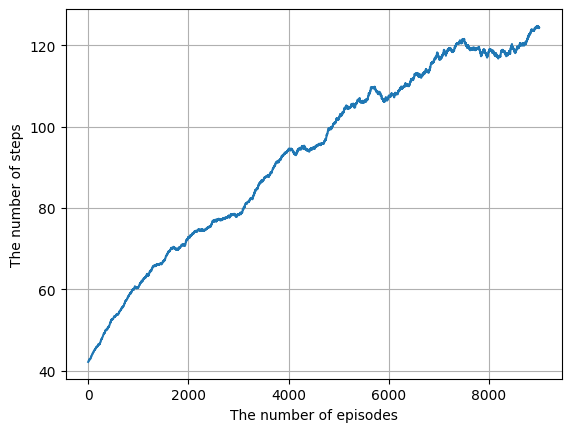

In [ ]:
# look rewards
smooth_cnt = []
for idx in range(len(loop_cnt_list)-1000):
    smooth_cnt.append(np.mean(loop_cnt_list[idx:idx+1000]))

# 绘图
plt.plot(smooth_cnt)
plt.xlabel("The number of episodes")  # 设置横坐标标签
plt.ylabel("The number of steps")     # 设置纵坐标标签
#plt.title("Performance over episodes")  # 可选：添加标题
plt.grid(True)  # 可选：添加网格线
plt.show()

In [ ]:
# view
env = gym.make('CartPole-v1')
s = env.reset()
for _ in range(300):
    env.render()
    s_for_a = trainer.take_state(s)
    a = actor.policy(s_for_a)
    n_state, reward, done, info = env.step(a)
    print(_, s_for_a, actor.Q[s_for_a],  reward, done)
    s = n_state

env.close()


0 [0. 0. 0. 0.] [1.99994494 1.99999986] 1.0 False
1 [ 0.   0.   0.  -0.3] [1.99999725 1.99999999] 1.0 False
2 [0. 0. 0. 0.] [1.99994494 1.99999986] 1.0 False
3 [ 0.   0.   0.  -0.2] [2.         1.99999987] 1.0 False
4 [ 0.   0.   0.  -0.5] [1.99999999 1.99999943] 1.0 False
5 [ 0.1  0.   0.  -0.2] [1.99999973 1.99999997] 1.0 False
6 [ 0.1  0.   0.  -0.5] [1.99999989 1.99999994] 1.0 False
7 [ 0.1  0.   0.  -0.8] [1.99998807 1.99770702] 1.0 False
8 [ 0.1 -0.  -0.  -1.1] [1.99611787 1.9914061 ] 1.0 False
9 [ 0.1 -0.  -0.  -1.4] [1.99653893 1.96593441] 1.0 False
10 [ 0.1 -0.1 -0.1 -1.1] [1.99875668 1.92085951] 1.0 False
11 [ 0.1 -0.1 -0.1 -1.4] [1.94911584 1.88051138] 1.0 False
12 [ 0.2 -0.1 -0.1 -1.7] [1.88107511 1.76137376] 1.0 False
13 [ 0.2 -0.2 -0.2 -2.1] [1.00004505 1.045045  ] 1.0 False
14 [ 0.2 -0.2 -0.2 -2.4] [1.0045  1.00045] 1.0 True
15 [ 0.2 -0.2 -0.2 -2.2] [1.45 1.  ] 0.0 True
16 [ 0.3 -0.3 -0.3 -2.5] [0.04816538 0.96619326] 0.0 True
17 [ 0.3 -0.3 -0.3 -2.9] [0.95671936 0.86535

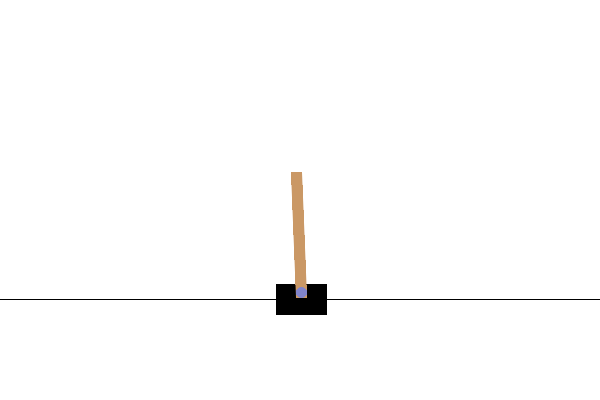

In [ ]:
import gym
from PIL import Image
from IPython.display import Image as IPImage, display

# 使用 render_mode 参数初始化环境
env = gym.make('CartPole-v1', render_mode="rgb_array")

# 初始化环境
# 初始化环境
reset_result = env.reset()
obs = reset_result[0]  # 提取 observation
image_append = []


for _ in range(100):
    # 获取渲染帧
    current_img = env.render()
    if isinstance(current_img, list):
        current_img = current_img[0]  # 如果是列表，取第一个元素
    current_img = Image.fromarray(current_img)
    image_append.append(current_img)

    # 采取随机动作
    s_for_a = trainer.take_state(s)
    a = actor.policy(s_for_a)
    n_state, reward, done, info = env.step(a)
    # print(_, s_for_a, actor.Q[s_for_a],  reward, done)
    s = n_state


env.close()

# 保存为 GIF
output_path = './sample_out.gif'
image_append[0].save(output_path, save_all=True, append_images=image_append, duration=40, loop=0)

# 显示 GIF
display(IPImage(output_path))
